<a href="https://colab.research.google.com/github/lcpbrandao/Projeto_Analytics_Producao_Industrial/blob/main/Projeto_Analytics_para_Produ%C3%A7%C3%A3o_Industrial_(v02).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analytics para Produção Industrial**
* Autor: Laislla Pinheiro Brandão
* Projeto para a etapa de seleção para a Residência Tecnológica em Ciência de Dados e Analytics para o setor Automotivo, 2022.
* Parceria UPE - FCA - Facepe

**DESAFIO**: 

*   Desenvolver um projeto de Análise ou Ciência de Dados sobre a base disponibilizada e preparar um *pitch* para defendê-lo.



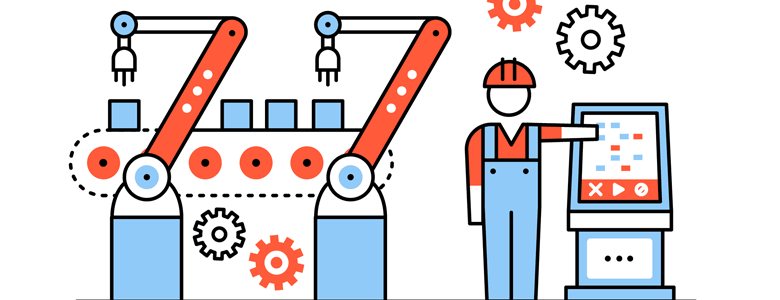

## **1 - COLETA DE DADOS**

In [15]:
#importando as bibliotecas básicas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from pandas_profiling import ProfileReport
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

# bibliotecas para séries temporais
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error as mse
#!pip install statsmodels --upgrade
#!pip install pmdarima
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

In [16]:
producao = pd.read_csv('/content/drive/MyDrive/EDUCAÇÃO/Residência em Ciência de Dados POLI-FCA 2022/Projeto Seleção RESITEC 2022/Base de Dados/Base de Dados - Selecao Resitec.csv')
# ordena os dados pela data, caso precise utilizar como série temporal, e remove index anterior
producao = producao.sort_values(by=['Data']).reset_index().drop(columns=['index'], axis = 1)
producao

,Data,Prod1,Prod2,Prod3
0,2014-12-01,0.0,11.0,0.0
1,2014-12-02,0.0,11.0,0.0
2,2014-12-03,0.0,11.0,0.0
3,2014-12-04,0.0,14.0,0.0
4,2014-12-05,0.0,13.0,0.0
...,...,...,...,...
2245,2022-10-27,142.0,264.0,272.0
2246,2022-10-28,155.0,302.0,285.0
2247,2022-10-29,124.0,234.0,225.0
2248,2022-10-30,46.0,77.0,70.0


## **2 - LIMPEZA E TRANSFORMAÇÃO**
#### Pré processamento dos dados, tratamento de missing values, joins, etc.

In [17]:
producao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    2250 non-null   object 
 1   Prod1   2244 non-null   float64
 2   Prod2   2248 non-null   float64
 3   Prod3   2247 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.4+ KB


In [18]:
# transforma a coluna String de Data para o formato DateTime
producao['Data'] = pd.to_datetime(producao['Data'], dayfirst = True)

In [19]:
# nova coluna com o total da produção
producao['Total_Prod'] = producao['Prod1'] + producao['Prod2'] + producao['Prod3']

#novas colunas com os meses e anos
producao['Semana'] = producao['Data'].dt.week.astype(str).map(lambda i: i.zfill(2))
producao['Mes'] = producao['Data'].dt.month.astype(str).map(lambda i: i.zfill(2))
producao['Ano'] = producao['Data'].dt.year.astype(str)
producao['Ano-Mes'] = producao['Ano'] + '-' + producao['Mes']
producao['Ano-Semana'] = producao['Ano'] + '-' + producao['Semana']

#nova coluna com os dias da semana
dias = ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-Feira','Sexta-feira','Sábado','Domingo']
producao['DiaDaSemana'] = producao['Data'].map(lambda i: dias[i.weekday()])

producao

<ipython-input-19-58f8b5ff4c83>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  producao['Semana'] = producao['Data'].dt.week.astype(str).map(lambda i: i.zfill(2))


,Data,Prod1,Prod2,Prod3,Total_Prod,Semana,Mes,Ano,Ano-Mes,Ano-Semana,DiaDaSemana
0,2014-12-01,0.0,11.0,0.0,11.0,49,12,2014,2014-12,2014-49,Segunda-feira
1,2014-12-02,0.0,11.0,0.0,11.0,49,12,2014,2014-12,2014-49,Terça-feira
2,2014-12-03,0.0,11.0,0.0,11.0,49,12,2014,2014-12,2014-49,Quarta-feira
3,2014-12-04,0.0,14.0,0.0,14.0,49,12,2014,2014-12,2014-49,Quinta-Feira
4,2014-12-05,0.0,13.0,0.0,13.0,49,12,2014,2014-12,2014-49,Sexta-feira
...,...,...,...,...,...,...,...,...,...,...,...
2245,2022-10-27,142.0,264.0,272.0,678.0,43,10,2022,2022-10,2022-43,Quinta-Feira
2246,2022-10-28,155.0,302.0,285.0,742.0,43,10,2022,2022-10,2022-43,Sexta-feira
2247,2022-10-29,124.0,234.0,225.0,583.0,43,10,2022,2022-10,2022-43,Sábado
2248,2022-10-30,46.0,77.0,70.0,193.0,43,10,2022,2022-10,2022-43,Domingo


In [20]:
# Contando quantos registros existem no dataframe
producao.count()

Data           2250
Prod1          2244
Prod2          2248
Prod3          2247
Total_Prod     2243
Semana         2250
Mes            2250
Ano            2250
Ano-Mes        2250
Ano-Semana     2250
DiaDaSemana    2250
dtype: int64

In [21]:
# Checando missing values
producao.isnull().sum()

Data           0
Prod1          6
Prod2          2
Prod3          3
Total_Prod     7
Semana         0
Mes            0
Ano            0
Ano-Mes        0
Ano-Semana     0
DiaDaSemana    0
dtype: int64

## **3 - ANÁLISE E EXPLORAÇÃO**


In [22]:
# Estatística descritiva dos dados
producao.describe()

,Prod1,Prod2,Prod3,Total_Prod
count,2244.000000,2248.000000,2247.000000,2243.000000
mean,199.451426,228.577847,174.949266,603.882746
std,111.265163,89.986105,116.266452,276.688128
min,0.000000,0.000000,0.000000,1.000000
25%,126.750000,203.000000,44.000000,432.000000
50%,234.000000,221.000000,219.000000,702.000000
75%,258.000000,268.000000,272.000000,797.000000
max,490.000000,630.000000,472.000000,1218.000000


#### Comportamento das séries de produção

PRODUÇÃO DIÁRIA

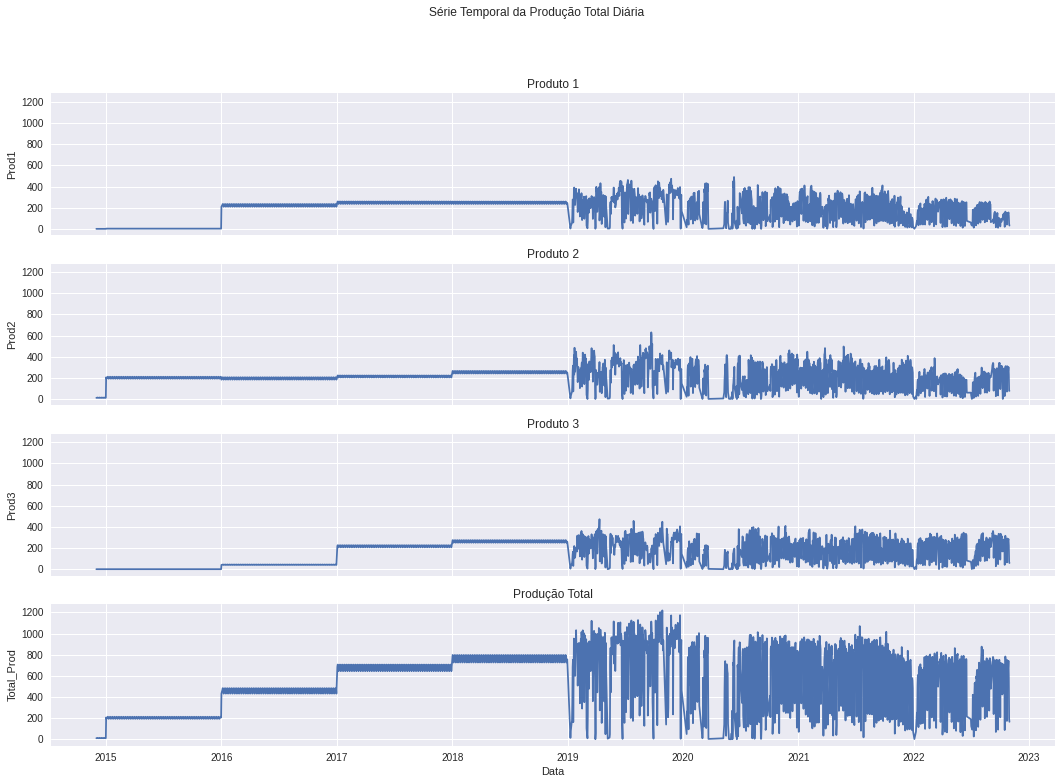

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharey=True, sharex=True)
fig.suptitle('Série Temporal da Produção Total Diária')

# Prod1
sns.lineplot(ax=axes[0], data=producao, x='Data', y='Prod1', palette = "viridis")
axes[0].set_title("Produto 1")
# Prod2
sns.lineplot(ax=axes[1], data=producao, x='Data', y='Prod2', palette = "viridis")
axes[1].set_title("Produto 2")
# Prod3
sns.lineplot(ax=axes[2], data=producao, x='Data', y='Prod3', palette = "viridis")
axes[2].set_title("Produto 3")
# Total_Prod
sns.lineplot(ax=axes[3], data=producao, x='Data', y='Total_Prod', palette = "viridis")
axes[3].set_title("Produção Total");

PRODUÇÃO SEMANAL

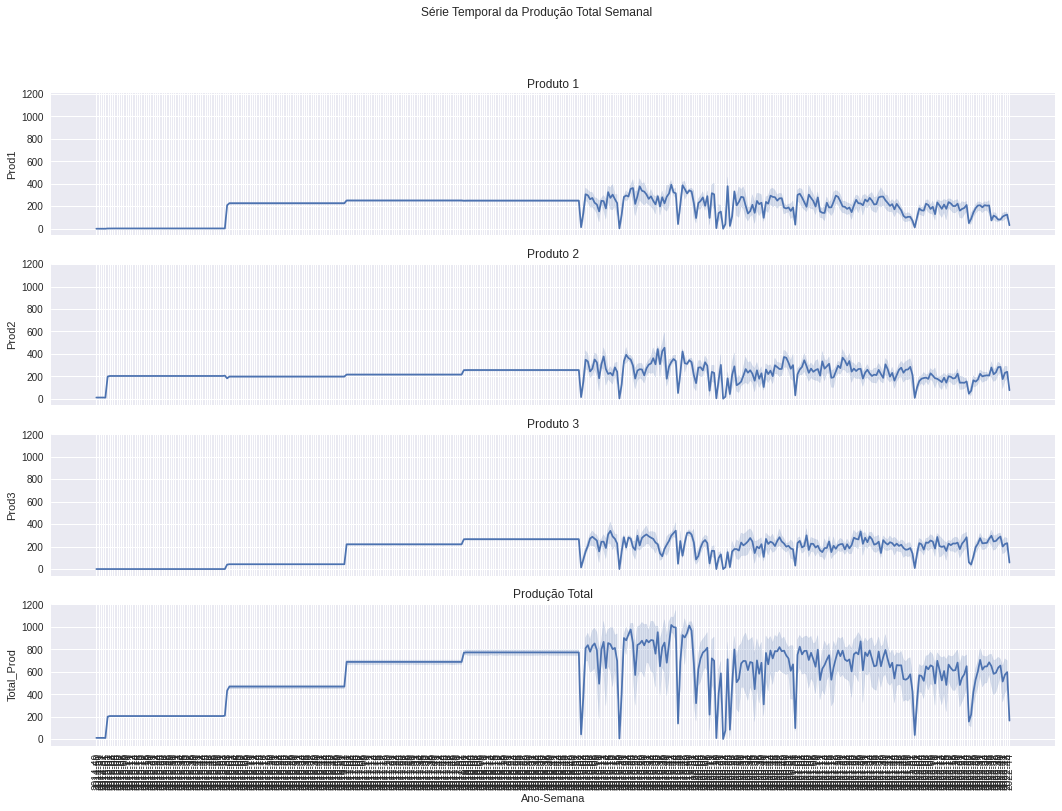

In [24]:
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharey=True, sharex=True)
fig.suptitle('Série Temporal da Produção Total Semanal')

# Prod1
sns.lineplot(ax=axes[0], data=producao, x='Ano-Semana', y='Prod1', palette = "viridis")
axes[0].set_title("Produto 1")
axes[0].tick_params(axis='x', labelrotation= 90)
# Prod2
sns.lineplot(ax=axes[1], data=producao, x='Ano-Semana', y='Prod2', palette = "viridis")
axes[1].set_title("Produto 2")
axes[1].tick_params(axis='x', labelrotation= 90)
# Prod3
sns.lineplot(ax=axes[2], data=producao, x='Ano-Semana', y='Prod3', palette = "viridis")
axes[2].set_title("Produto 3")
axes[2].tick_params(axis='x', labelrotation= 90)
# Total_Prod
sns.lineplot(ax=axes[3], data=producao, x='Ano-Semana', y='Total_Prod', palette = "viridis")
axes[3].set_title("Produção Total")
axes[3].tick_params(axis='x', labelrotation= 90)

PRODUÇÃO MENSAL

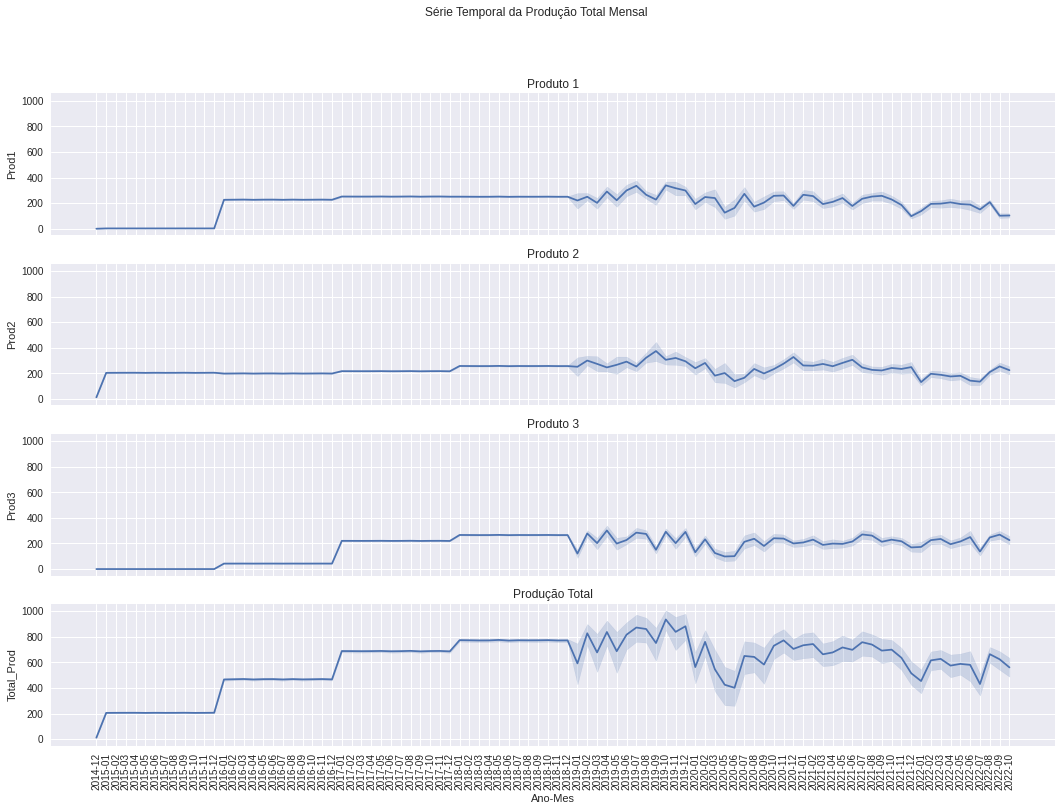

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharey=True, sharex=True)
fig.suptitle('Série Temporal da Produção Total Mensal')

# Prod1
sns.lineplot(ax=axes[0], data=producao, x='Ano-Mes', y='Prod1', palette = "viridis")
axes[0].set_title("Produto 1")
axes[0].tick_params(axis='x', labelrotation= 90)
# Prod2
sns.lineplot(ax=axes[1], data=producao, x='Ano-Mes', y='Prod2', palette = "viridis")
axes[1].set_title("Produto 2")
axes[1].tick_params(axis='x', labelrotation= 90)
# Prod3
sns.lineplot(ax=axes[2], data=producao, x='Ano-Mes', y='Prod3', palette = "viridis")
axes[2].set_title("Produto 3")
axes[2].tick_params(axis='x', labelrotation= 90)
# Total_Prod
sns.lineplot(ax=axes[3], data=producao, x='Ano-Mes', y='Total_Prod', palette = "viridis")
axes[3].set_title("Produção Total")
axes[3].tick_params(axis='x', labelrotation= 90)

PRODUÇÃO ANUAL

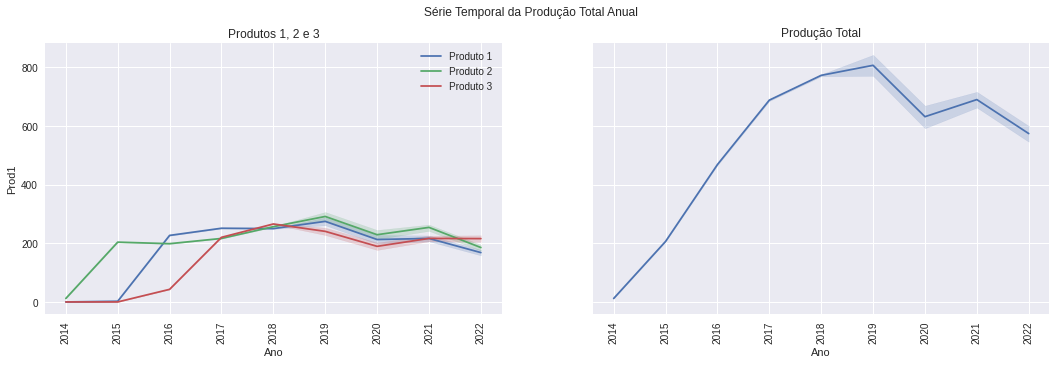

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey='all', sharex=True)
fig.suptitle('Série Temporal da Produção Total Anual')
plt.xticks(rotation=90)

# Prod1, Prod2 e Prod3
sns.lineplot(ax=axes[0], data=producao, x='Ano', y='Prod1', palette = "viridis", label = "Produto 1")
sns.lineplot(ax=axes[0], data=producao, x='Ano', y='Prod2', palette = "viridis", label = "Produto 2")
sns.lineplot(ax=axes[0], data=producao, x='Ano', y='Prod3', palette = "viridis", label = "Produto 3")
axes[0].set_title("Produtos 1, 2 e 3")
axes[0].tick_params(axis='x', labelrotation= 90)

# Total_Prod
sns.lineplot(ax=axes[1], data=producao, x='Ano', y='Total_Prod', palette = "viridis")
axes[1].set_title("Produção Total")
axes[1].tick_params(axis='x', labelrotation= 90)

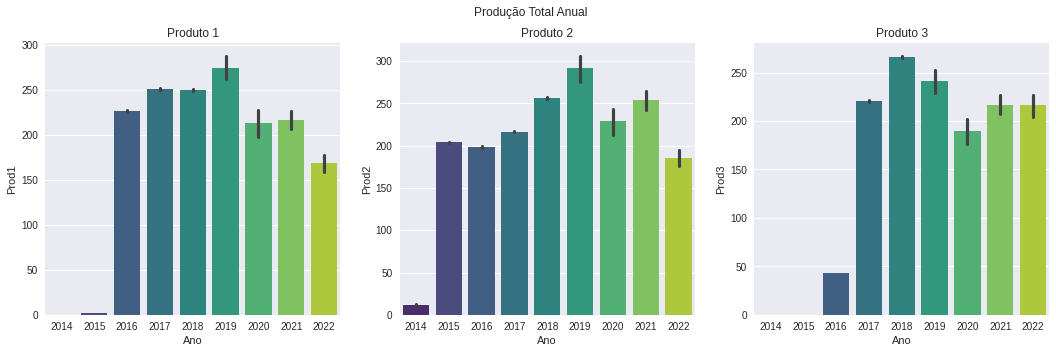

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Produção Total Anual')

# Prod1
sns.barplot(ax=axes[0], data=producao, x='Ano', y='Prod1', palette = "viridis", label = "Produto 1")
axes[0].set_title("Produto 1")
# Prod2
sns.barplot(ax=axes[1], data=producao, x='Ano', y='Prod2', palette = "viridis", label = "Produto 2")
axes[1].set_title("Produto 2")
# Prod3
sns.barplot(ax=axes[2], data=producao, x='Ano', y='Prod3', palette = "viridis", label = "Produto 3")
axes[2].set_title("Produto 3");

#### Histograma dos produtos 


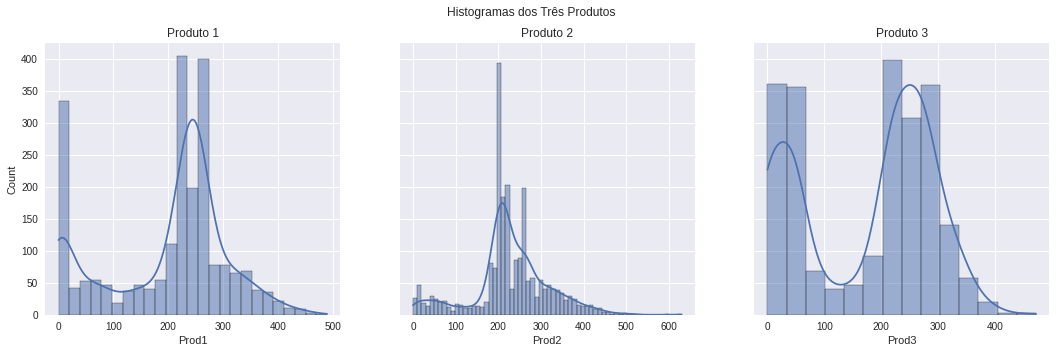

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Histogramas dos Três Produtos')

# Prod1
sns.histplot(ax=axes[0], data=producao, x='Prod1', kde=True)
axes[0].set_title("Produto 1")
# Prod2
sns.histplot(ax=axes[1], data=producao, x='Prod2', kde=True)
axes[1].set_title("Produto 2")
# Prod3
sns.histplot(ax=axes[2], data=producao, x='Prod3', kde=True)
axes[2].set_title("Produto 3");

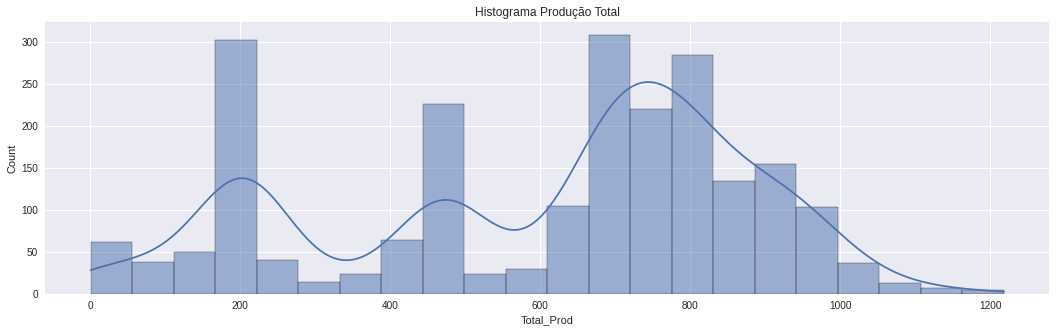

In [29]:
# Total_Prod
plt.figure(figsize=(18,5))
sns.histplot(data=producao, x='Total_Prod', kde=True).set_title("Histograma Produção Total");

#### Variabilidade dos dados - ViolinPlot

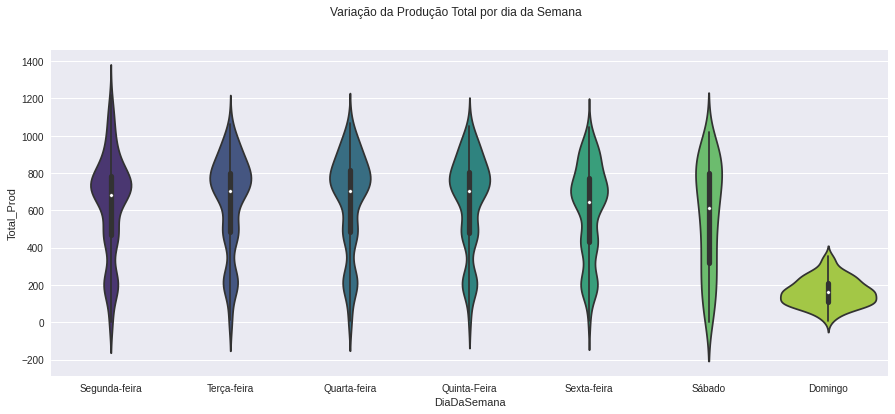

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Variação da Produção Total por dia da Semana')
# axes.yaxis.grid(True)
sns.violinplot(data=producao, y='Total_Prod', x='DiaDaSemana', palette = "viridis");

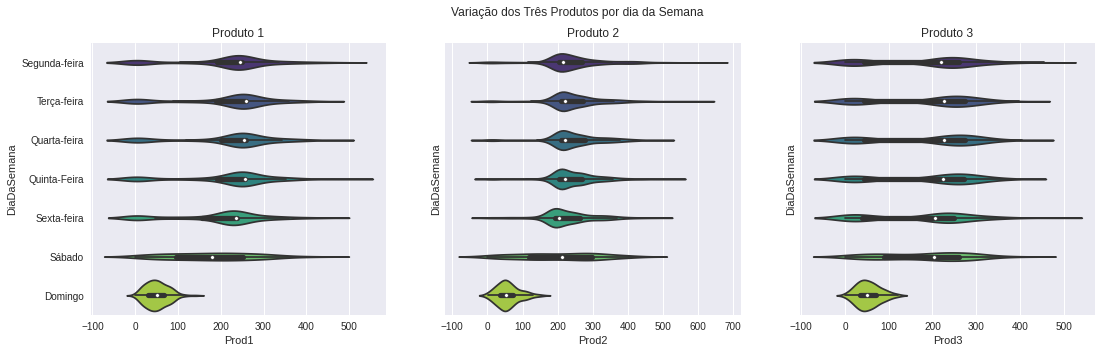

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Variação dos Três Produtos por dia da Semana')

# Prod1
sns.violinplot(ax=axes[0], data=producao, x='Prod1', y='DiaDaSemana', palette = "viridis")
axes[0].set_title("Produto 1")
# Prod2
sns.violinplot(ax=axes[1], data=producao, x='Prod2', y='DiaDaSemana', palette = "viridis")
axes[1].set_title("Produto 2")
# Prod3
sns.violinplot(ax=axes[2], data=producao, x='Prod3', y='DiaDaSemana', palette = "viridis");
axes[2].set_title("Produto 3");

#### Variabilidade dos dados - BoxPlot

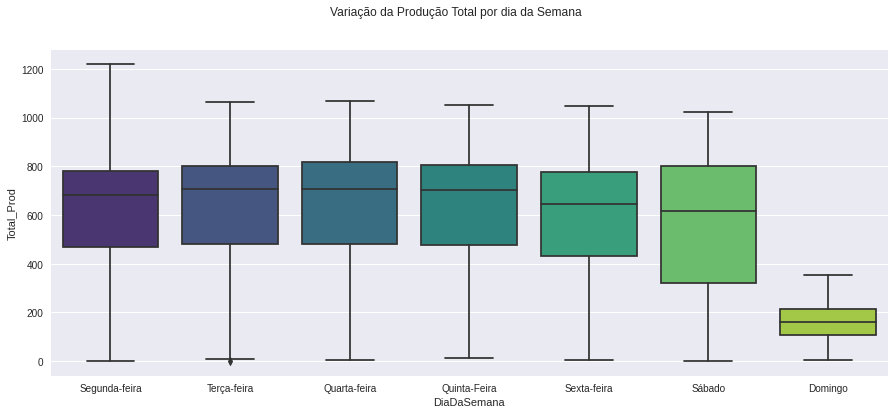

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Variação da Produção Total por dia da Semana')

sns.boxplot(data=producao, y='Total_Prod', x='DiaDaSemana', palette = "viridis");

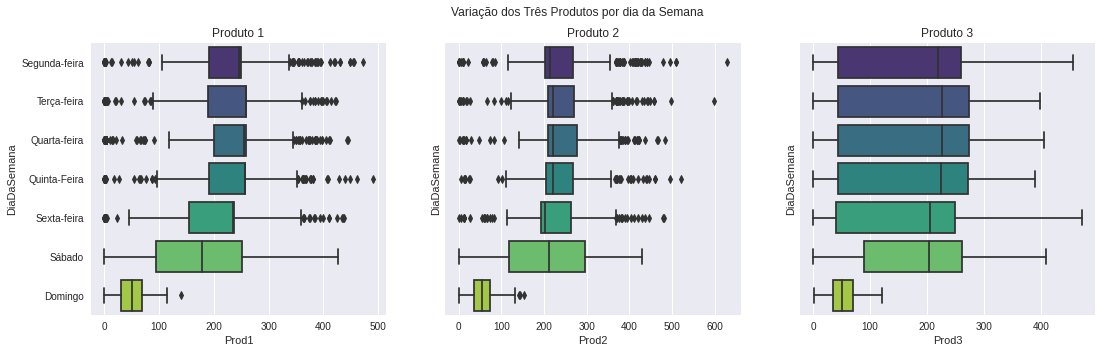

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Variação dos Três Produtos por dia da Semana')

# Prod1
sns.boxplot(ax=axes[0], data=producao, x='Prod1', y='DiaDaSemana', palette = "viridis")
axes[0].set_title("Produto 1")
# Prod2
sns.boxplot(ax=axes[1], data=producao, x='Prod2', y='DiaDaSemana', palette = "viridis")
axes[1].set_title("Produto 2")
# Prod3
sns.boxplot(ax=axes[2], data=producao, x='Prod3', y='DiaDaSemana', palette = "viridis");
axes[2].set_title("Produto 3");

#### Correlações entre os produtos

In [34]:
# Calcula a correlação (aqui a correlação calculada é a de )
correlacoes = producao.corr("pearson")

*   *O coeficiente de correlação varia de `-1` a `1`. 
Se valor é próximo de 1, isto significa que existe uma forte correlação positiva entre as variáveis. Quando esse número é próximo de -1, as variáveis tem uma forte correlação negativa.*

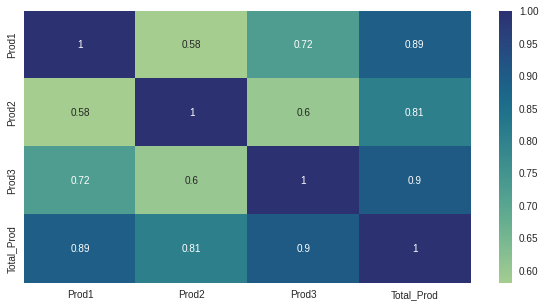

In [35]:
# Usando o método heatmap do seaborn
%matplotlib inline
plt.figure(figsize=(10, 5))
sns.heatmap(data=correlacoes, cmap = "crest", annot=True);

#### Dispersão dos dados

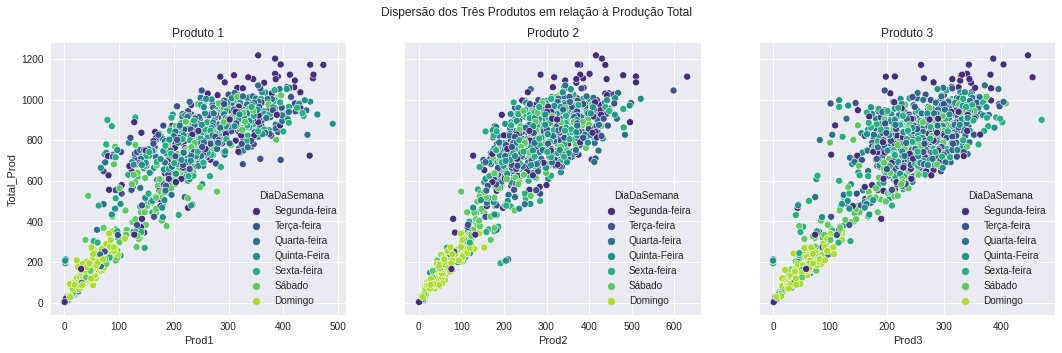

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Dispersão dos Três Produtos em relação à Produção Total')

# Prod1
sns.scatterplot(ax=axes[0], data=producao, x='Prod1', y='Total_Prod', hue='DiaDaSemana', palette = "viridis");
axes[0].set_title("Produto 1")
# Prod2
sns.scatterplot(ax=axes[1], data=producao, x='Prod2', y='Total_Prod', hue='DiaDaSemana', palette = "viridis");
axes[1].set_title("Produto 2")
# Prod3
sns.scatterplot(ax=axes[2], data=producao, x='Prod3', y='Total_Prod', hue='DiaDaSemana', palette = "viridis");
axes[2].set_title("Produto 3");

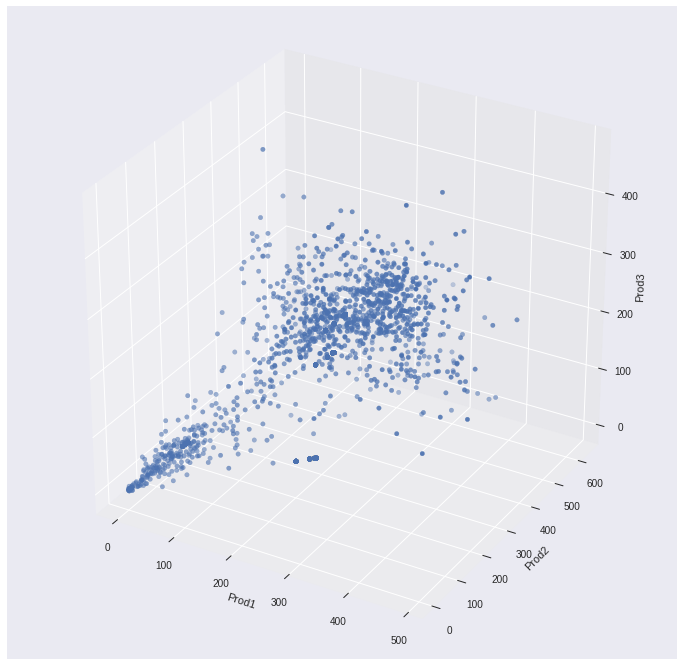

In [37]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("Prod1")
ax.set_ylabel("Prod2")
ax.set_zlabel("Prod3")

x = producao['Prod1']
y = producao['Prod2']
z = producao['Prod3']

ax.scatter(x, y, z)
plt.show();

## **4 - MODELAGEM DE SÉRIES TEMPORAIS**

#### Séries Temporais de Produção Semanal e Mensal

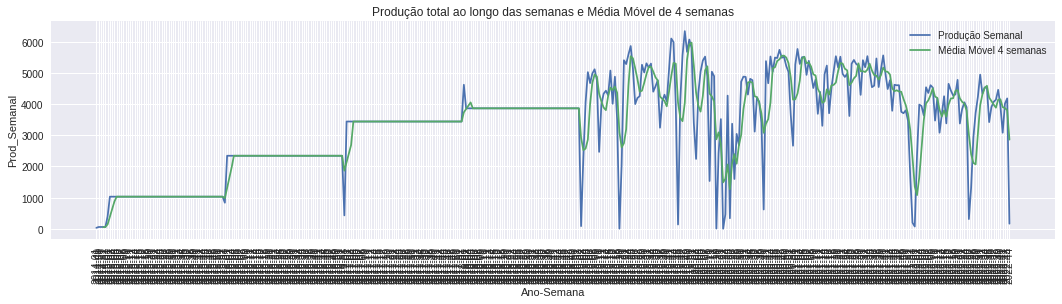

In [39]:
# criação de DataFrame para produção semanal
producao_semanal = pd.DataFrame(data = producao.groupby(['Ano-Semana']).agg({'Total_Prod': ['sum']})).reset_index()
producao_semanal.columns = ['Ano-Semana', 'Prod_Semanal']
# coluna com a Média Móvel das últimas 4 semanas
producao_semanal['MM_4'] = producao_semanal['Prod_Semanal'].rolling(4).mean()

# Plot da produção semanal
fig, axes = plt.subplots(1, 1, figsize=(18, 4))
sns.lineplot(data=producao_semanal, x='Ano-Semana', y='Prod_Semanal', label = "Produção Semanal")
sns.lineplot(data=producao_semanal, x='Ano-Semana', y='MM_4', label = "Média Móvel 4 semanas")
axes.set_title('Produção total ao longo das semanas e Média Móvel de 4 semanas')
axes.tick_params(axis='x', labelrotation= 90);

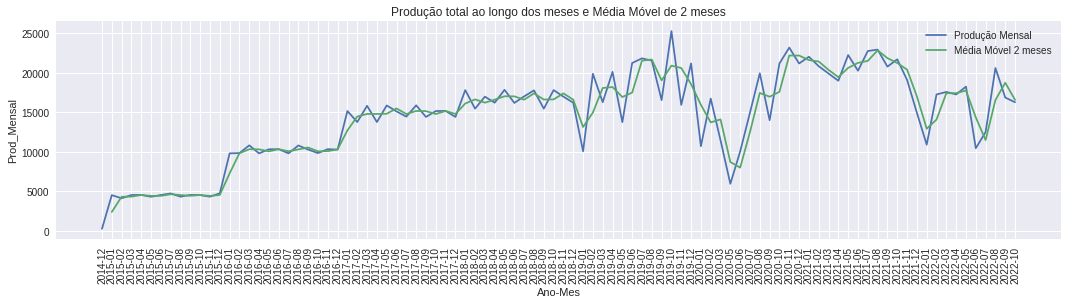

In [40]:
# criação de DataFrame para produção semamal
producao_mensal = pd.DataFrame(data = producao.groupby(['Ano-Mes']).agg({'Total_Prod': ['sum']})).reset_index()
producao_mensal.columns = ['Ano-Mes', 'Prod_Mensal']
# coluna com a Média Móvel dos últimos 2 meses
producao_mensal['MM_1'] = producao_mensal['Prod_Mensal'].rolling(2).mean()

# Plot da produção mensal
fig, axes = plt.subplots(1, 1, figsize=(18, 4))
sns.lineplot(data=producao_mensal, x='Ano-Mes', y='Prod_Mensal', label = "Produção Mensal")
sns.lineplot(data=producao_mensal, x='Ano-Mes', y='MM_1', label = "Média Móvel 2 meses")
axes.set_title('Produção total ao longo dos meses e Média Móvel de 2 meses')
axes.tick_params(axis='x', labelrotation= 90);

In [41]:
# tranforma o dataframes de produção em séries temporais
S_prodSemanal = pd.Series(data = producao_semanal['Prod_Semanal'].values, index = producao_semanal['Ano-Semana'])
S_prodMensal = pd.Series(data = producao_mensal['Prod_Mensal'].values, index = producao_mensal['Ano-Mes'])

#### PRODUÇÃO MENSAL

##### MENSAL | Split dados - Treino e Teste

In [42]:
trainSize2 = int(np.floor(0.7*len(S_prodMensal)))   #70%
print(trainSize2)
testSize2 = len(S_prodMensal) - trainSize2    #30%
print(testSize2)

65
29


In [43]:
x_treino2 = S_prodMensal[:trainSize2]
x_test2 = S_prodMensal[trainSize2:]

##### MENSAL | Análise de Autocorrelações

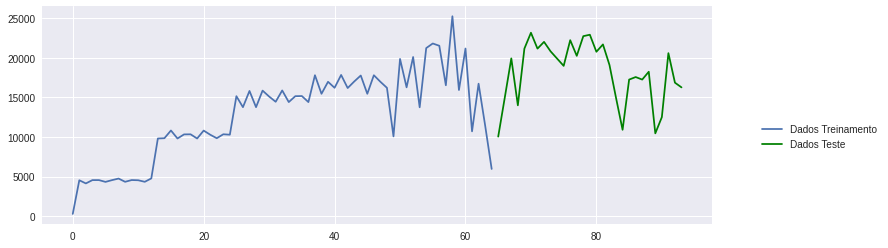

In [45]:
plt.plot(range(trainSize2),x_treino2)
plt.plot(range(trainSize2,trainSize2+testSize2),x_test2, color='green')
plt.legend(['Dados Treinamento', 'Dados Teste'], loc='upper right', bbox_to_anchor=(0.76, 0.1, 0.5, 0.4))
rcParams['figure.figsize'] = 12, 4
plt.show()

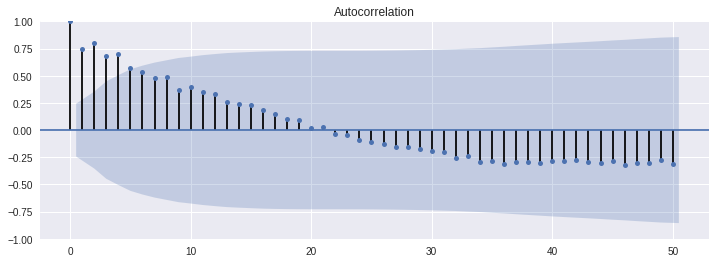

In [46]:
# Análise das Autocorrelações
plot_acf(x_treino2,lags=50);

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


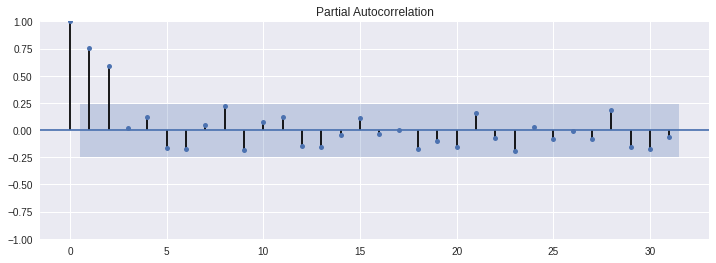

In [47]:
# Análise das Autocorrelações Parciais
plot_pacf(x_treino2,lags=31);

##### MENSAL | Decomposição da série

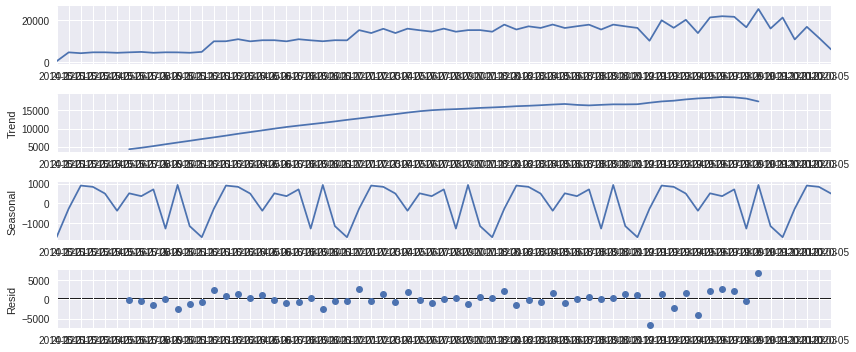

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposicao = seasonal_decompose(x_treino2, period=12, model='addictive')
rcParams['figure.figsize'] = 12, 5
decomposicao.plot();

##### MENSAL | Estacionariedade

In [49]:
import statsmodels.tsa.stattools

# função para verificar se a série é estacionária
def estacionaria(df):
    kpss = statsmodels.tsa.stattools.kpss(df)
    #print('Estatítica do teste: {:.4f}'.format(kpss[0]))
    #print('p_valor: {:.4f}'.format(kpss[1]))
    if (kpss[1] < 0.4630): #utilizando 5%
        print("Série É Estacionária.")
    else:
        print("Série NÃO É Estacionária.")

In [50]:
# verificação da estacionariedade
estacionaria(x_treino2)

Série É Estacionária.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


##### MENSAL | GridSearch (Auto Arima)

In [51]:
from pmdarima.arima import auto_arima

modelo_auto_mensal = auto_arima(x_treino2, trace = True, stepwise = False, seasonal=True, max_p=10, max_q=10,
                         max_P=0, max_Q=0, start_p=0, start_q=0, start_P=0, start_Q=0, m=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1232.242, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1209.613, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1199.780, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=1203.071, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[12] intercept   : AIC=1188.727, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1198.332, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1200.323, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1201.988, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=1202.725, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[12] intercept   : AIC=1191.141, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1200.338, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1202.241, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1200.461, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=1197.451, Time=0.39 sec


##### MENSAL | Resultado do Modelo Auto-Arima (Escolha do modelo ARIMA(0,1,5))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


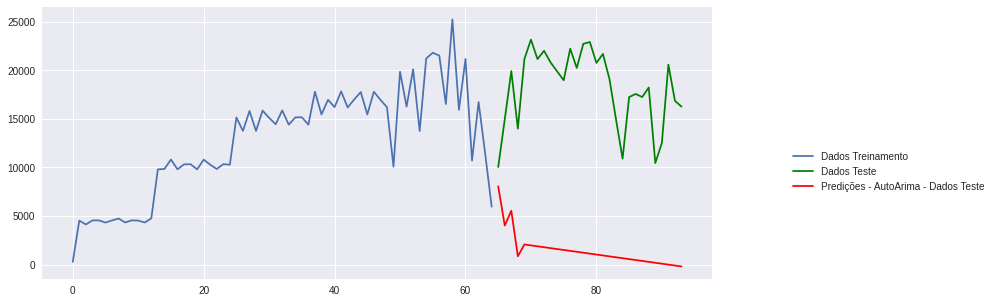

In [52]:
# Predição multistep único utilizando o AUTOARIMA
Residuo_AUTOARIMA_DT2 = np.subtract(x_test2.tolist(),modelo_auto_mensal.predict(testSize2))

plt.plot(range(trainSize2),x_treino2)
plt.plot(range(trainSize2,trainSize2+testSize2),x_test2, color='green')
plt.plot(range(trainSize2,trainSize2+testSize2),modelo_auto_mensal.predict(testSize2), color='red')

plt.legend(['Dados Treinamento', 'Dados Teste', 
            'Predições - AutoArima - Dados Teste'], loc='upper right', bbox_to_anchor=(0.92, 0.1, 0.5, 0.4))

rcParams['figure.figsize'] = 12, 4
plt.show()

##### MENSAL | Treinamento e Predições do modelo ARIMA (5,0,3)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Predicoes_ARIMA_DT2=[]
x_treino_temp2 = x_treino2.copy().tolist()

modelo_arma_mensal = ARIMA(pd.Series(x_treino_temp2) , order=(5, 0, 3)).fit()
temp = modelo_arma_mensal.forecast(1)
Predicoes_ARIMA_DT2.append(temp[trainSize2])
x_treino_temp2.append(temp[trainSize2])

for i in range(testSize2-1):
  modelo_arma_mensal = ARIMA(pd.Series(x_treino_temp2), order=(5, 0, 3)).fit()
  temp = modelo_arma_mensal.forecast(trainSize2+i)
  Predicoes_ARIMA_DT2.append(temp[trainSize2+1+i])
  x_treino_temp2.append(temp[trainSize2+1+i])

##### MENSAL | Plot do resultado do Modelo ARIMA

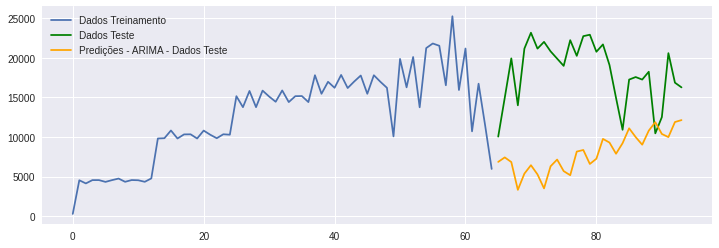

In [54]:
plt.plot(range(trainSize2),x_treino2)
plt.plot(range(trainSize2,trainSize2+testSize2),x_test2, color='green')

plt.plot(range(trainSize2,trainSize2+testSize2), Predicoes_ARIMA_DT2, color='orange')

plt.legend(['Dados Treinamento', 
            'Dados Teste',
            'Predições - ARIMA - Dados Teste'])
rcParams['figure.figsize'] = 12, 4
plt.show()

##### MENSAL | Plot dos Resíduos

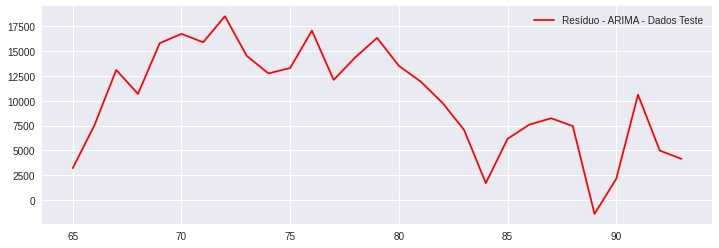

In [55]:
Residuos_ARIMA_DT2 = np.subtract(x_test2.tolist(),Predicoes_ARIMA_DT2)

Residuos_ARIMA_DT2
plt.plot(range(trainSize2,trainSize2+len(Residuos_ARIMA_DT2)),Residuos_ARIMA_DT2, color='red')
plt.legend(['Resíduo - ARIMA - Dados Teste'])

rcParams['figure.figsize'] = 12, 4
plt.show()

##### MENSAL | Modelagem Não-Linear para Hibridizar a Predição e melhorar o Desempenho

In [56]:
# definição de função para criar o lag no conjunto de dados
def create_windowing(df, lag_size):
    final_df = None
    for i in range(0, (lag_size + 1)):
        serie = df.shift(i)
        if (i == 0):
            serie.columns = ['actual']
        else:
            serie.columns = [str('lag' + str(i))]
        final_df = pd.concat([serie, final_df], axis=1)

    return final_df.dropna()

In [91]:
# criação de modelo não linear MLP para modelar os resíduos
Modelo_MLP = MLPRegressor(hidden_layer_sizes=(100,100,100,100))

# normalização dos resíduos
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(Residuos_ARIMA_DT2[0:len(x_test2)].reshape(-1, 1))
normalized_error = min_max_scaler.transform(Residuos_ARIMA_DT2.reshape(-1, 1))

Residuos_NL_DT2 = pd.DataFrame({'Residuos': normalized_error.flatten()})

In [92]:
# definição do LAG para os dados da série
time_window = 3

# deslocamento da série para criar os lags que serão usados no modelo
Residuos_NL_DT2_LAG = create_windowing(df=Residuos_NL_DT2, lag_size=time_window)
Residuos_NL_DT2_LAG.head()

,lag3,lag2,lag1,actual
3,0.231349,0.449316,0.728310,0.606840
4,0.449316,0.728310,0.606840,0.863765
5,0.728310,0.606840,0.863765,0.910853
6,0.606840,0.863765,0.910853,0.868449
7,0.863765,0.910853,0.868449,1.000000


In [93]:
# separação em Treino e Teste dos dados de resíduo após o lag
y_train_NL = Residuos_NL_DT2_LAG['actual'][0:trainSize2]
x_train_NL = Residuos_NL_DT2_LAG.drop(columns=['actual'], axis=1)[0:trainSize2]

# treinamento do modelo Não Linear MLP
Modelo_MLP_DT = Modelo_MLP.fit(x_train_NL, y_train_NL)

In [94]:
# predição dos valores de resíduo e desnormalização para voltar à ordem de grandeza original
Predicoes_NL_DT = Modelo_MLP_DT.predict(Residuos_NL_DT2_LAG.drop(columns=['actual'], axis=1))
Predicoes_NL_DT = min_max_scaler.inverse_transform(Predicoes_NL_DT.reshape(-1, 1)).flatten()

# resultado da predição Final com a soma das predições do ARIMA com as predições da MLP
Predicoes_Final_DT = Predicoes_ARIMA_DT2[time_window:] + Predicoes_NL_DT

##### MENSAL | Plot dos dados x Predição TOTAL

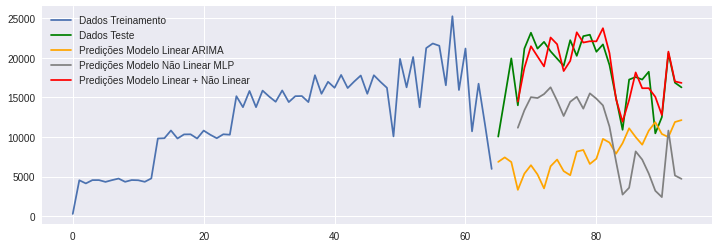

In [95]:
plt.plot(range(trainSize2),x_treino2)
plt.plot(range(trainSize2,trainSize2+testSize2), x_test2, color = 'green')

plt.plot(range(trainSize2,trainSize2+testSize2),Predicoes_ARIMA_DT2, color = 'orange')
plt.plot(range(trainSize2+time_window,trainSize2+testSize2),Predicoes_NL_DT, color = 'grey')
plt.plot(range(trainSize2+time_window,trainSize2+testSize2),Predicoes_Final_DT, color = 'red')

plt.legend(['Dados Treinamento', 
            'Dados Teste', 
            'Predições Modelo Linear ARIMA', 
            'Predições Modelo Não Linear MLP',
            'Predições Modelo Linear + Não Linear'])

rcParams['figure.figsize'] = 12, 4
plt.show()

##### MENSAL | Métricas Dados Teste (Mean Squared Error - MSE)

In [96]:
from sklearn.metrics import mean_squared_error as mse 
ERRO_MSE_ARIMA_DT2 = mse(x_test2, Predicoes_ARIMA_DT2)
print('MSE Modelo Linear ARMA(5,0,3) para série MENSAL = %.2f'%ERRO_MSE_ARIMA_DT2)

MSE Modelo Linear ARMA(5,0,3) para série MENSAL = 130926832.96


In [97]:
ERRO_MSE_FINAL2 = mse(x_test2[time_window:], Predicoes_Final_DT)
print('MSE Modelos Linear + Não Linear MLP para série MENSAL = %.2f'%ERRO_MSE_FINAL2)

MSE Modelos Linear + Não Linear MLP para série MENSAL = 3347769.24
